In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
import torch.optim as optim
from matplotlib import pyplot as plt
import numpy as np

In [2]:
latent_size = 8
w = h = 256
C = 3
class VAEModel(nn.Module):
    def __init__(self) -> None:
        super(VAEModel, self).__init__()
        self.conv1 = nn.Conv2d(1, C, kernel_size=(3, 3), stride=1, padding=1)

        self.en_cell_bn1 = nn.BatchNorm2d(C)
        self.en_cell_bn2 = nn.BatchNorm2d(C)
        self.en_conv1 = nn.Conv2d(C, C, kernel_size=(3, 3), stride=1, padding=1)
        self.en_conv2 = nn.Conv2d(C, C, kernel_size=(3, 3), stride=1, padding=1)

        self.en_se_fc1 = nn.Linear(C, 2)
        self.en_se_fc2 = nn.Linear(2, C)

        self.fc_mu = nn.Linear(w*h*C, latent_size)
        self.fc_log_sigma = nn.Linear(w*h*C, latent_size)

        self.de_cell_bn1 = nn.BatchNorm2d(C)
        self.de_cell_bn2 = nn.BatchNorm2d(C)
        self.de_cell_bn3 = nn.BatchNorm2d(C)
        self.de_cell_bn4 = nn.BatchNorm2d(C)

        self.de_conv1 = nn.Conv2d(C, C, kernel_size=(1, 1))
        self.de_conv2 = nn.Conv2d(C, C, kernel_size=(5, 5), stride=1, padding=2)
        self.de_conv3 = nn.Conv2d(C, C, kernel_size=(1, 1))
        
        self.de_se_fc1 = nn.Linear(C, 2)
        self.de_se_fc2 = nn.Linear(2, C)

        self.latent_de = nn.Linear(latent_size, w*h)
        self.conv2 = nn.Conv2d(1, C, kernel_size=(1, 1))
        self.conv3 = nn.Conv2d(C, 1, kernel_size=(1, 1))

    def encoder_cell(self, x):
        residual = torch.clone(x)
        x = F.silu(self.en_cell_bn1(x))
        x = self.en_conv1(x)
        x = F.silu(self.en_cell_bn2(x))
        x = self.en_conv2(x)
        se = x.mean(dim=(-2, -1))
        se = self.en_se_fc1(se)
        se = F.relu(se)
        se = self.en_se_fc2(se)
        se = torch.sigmoid(se)
        return x.mul(se.view(-1, C, 1, 1)).add_(residual)

    def decoder_cell(self, x):
        residual = torch.clone(x)
        x = self.de_cell_bn1(x)
        x = self.de_conv1(x)
        x = F.silu(self.de_cell_bn2(x))
        x = self.de_conv2(x)
        x = F.silu(self.de_cell_bn3(x))
        x = self.de_conv3(x)
        x = self.de_cell_bn4(x)
        se = x.mean(dim=(-2, -1))
        se = self.de_se_fc1(se)
        se = F.relu(se)
        se = self.de_se_fc2(se)
        se = torch.sigmoid(se)
        return x.mul(se.view(-1, C, 1, 1)).add_(residual)

    def encode(self, x):
        x = self.conv1(x)
        for i in range(3):
            x = self.encoder_cell(x) # more cells can be added after this line
        x = x.view(-1, C*w*h)
        mu = self.fc_mu(x)
        log_sigma = self.fc_log_sigma(x)
        return mu, log_sigma

    def decode(self, x):
        x = self.latent_de(x)
        x = x.view(-1, 1, w, h)
        x = self.conv2(x)
        for i in range(3):
            x = self.decoder_cell(x) # more cells can be added after this line
        x = self.conv3(x)
        return x

    def reparameterize(self, mu, log_sigma):
        std = torch.exp(0.5*log_sigma)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        x = x.view(-1, 1, w, h) # add channel dimension
        mu, log_sigma = self.encode(x) # log sigma is more stable (numerically)
        z = self.reparameterize(mu, log_sigma)
        x_hat = self.decode(z)
        return x_hat.view(-1, w, h), mu, log_sigma

In [3]:
model = VAEModel()

# Check model
A = torch.randn((10, w, h))
B, mu_B, log_sigma_B = model.forward(A)
B.shape, mu_B.shape, log_sigma_B.shape

(torch.Size([10, 256, 256]), torch.Size([10, 8]), torch.Size([10, 8]))

In [4]:
mse_loss = nn.MSELoss(reduction='mean')
def loss_fn(x, x_hat, mu, log_sigma): # input, reconstructed input
    MSE = mse_loss(x_hat, x)
    BCE = F.binary_cross_entropy_with_logits(x_hat, x, reduction='mean')
    KLD = 0.5*torch.sum(log_sigma.exp() + mu.pow(2) - log_sigma - 1) # KL divergence
    loss = BCE + MSE + KLD # reduce both bce and mse
    return loss

In [5]:
def draw(x, x_hat):
    fig, axs = plt.subplots(1, 2, figsize=(8,5))
    img_0 = x[0].detach().numpy()
    img_1 = x_hat[0].detach().numpy()
    #img = img.reshape((-1, 28, 28)).transpose((1, 0, 2)).reshape(-1, 10*28)
    #img = img * 0.3081 + 0.1307
    axs[0].imshow(img_0, cmap='gray')
    axs[1].imshow(img_1, cmap='gray')
    fig.canvas.draw()

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
model = model.to(device)
#optimizer = optim.Adam(model.parameters(), lr=1e-6)
optimizer = optim.SGD(model.parameters(), lr=1e-6, momentum=0.9)

In [7]:
def train_epoch(model, optimizer, train_loader):
    model.train()
    losses = 0

    for x in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        x_hat, mu, log_sigma = model.forward(x)
        loss = loss_fn(x, x_hat, mu, log_sigma)
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(train_loader)

In [8]:
def evaluate(model, dev_loader):
    model.eval()
    losses = 0

    for x in dev_loader:
        x = x.to(device)
        x_hat, mu, log_sigma = model.forward(x)
        loss = loss_fn(x, x_hat, mu, log_sigma)
        losses += loss.item()

    return losses / len(dev_loader)

In [9]:
def make_loaders():
    batch_size = 8
    chunk_no = np.random.randint(1, 12)
    train_data = torch.load(f'augmenteddata/data_chunk_{chunk_no}.pt')
    dev_data = torch.load(f'augmenteddata/data_chunk_{12}.pt')
    #dev_set = D.Dataset(dev_data)
    #train_set = D.Dataset(train_data)
    train_loader = D.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    dev_loader = D.DataLoader(dev_data, batch_size=batch_size, shuffle=True)
    return train_loader, dev_loader

In [12]:
model = torch.load('models/model_7_all_chunks_random_12_dev')
train_losses = []
dev_losses = []

In [14]:
from timeit import default_timer as timer
NUM_EPOCHS = 50

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loader, dev_loader = make_loaders()
    train_loss = train_epoch(model, optimizer, train_loader)
    train_losses.append(train_loss)
    end_time = timer()
    dev_loss = evaluate(model, dev_loader)
    dev_losses.append(dev_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Dev loss: {dev_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 0.700, Dev loss: 0.760, Epoch time = 118.334s
Epoch: 2, Train loss: 0.708, Dev loss: 0.742, Epoch time = 205.473s


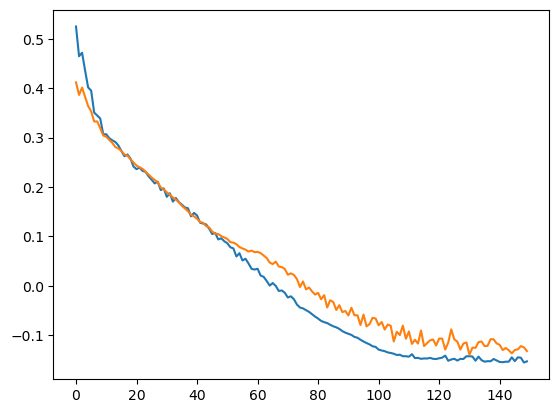

In [40]:
torch.save(model, 'models/model_8_all_chunks_random_12_dev_sgd')
torch.save(torch.Tensor(train_losses), 'losses/train_losses_model_8_sgd')
torch.save(torch.Tensor(dev_losses), 'losses/dev_losses_model_8_sgd')
plt.plot(np.log10(train_losses))
plt.plot(np.log10(dev_losses))

tensor(0.0251, device='cuda:0', grad_fn=<MseLossBackward0>)

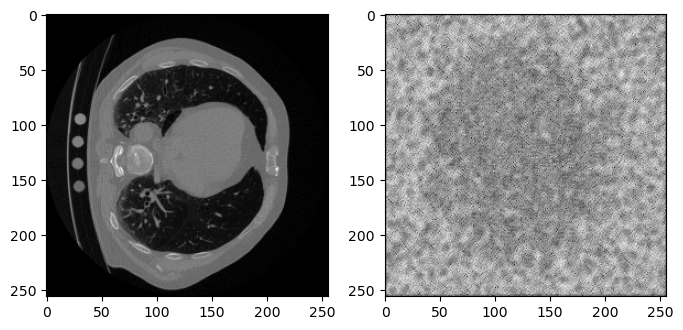

In [41]:
model.eval()
x_test = next(iter(dev_loader))[0].view(1, 256, 256).to(device)
x_hat_test = model.forward(x_test)[0]
draw(x_test.cpu(), x_hat_test.cpu())
mse_loss(x_test, x_hat_test)